In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from .logger import Logger
from datetime import datetime
import os
import seaborn as sns

In [ ]:
logger = Logger('../data_transformation/data_transformation_log.log')
today = datetime.today().strftime("%Y\\%m\\%d")

In [3]:
cleanedDataset_path = '..\\5. Data Preparation'
csvName = 'cleaned_churn_dataset.csv'
sources = ['HuggingFace', 'Kaggle']

df_hf = pd.read_csv(os.path.join(cleanedDataset_path, sources[0], today, csvName))
df_kg = pd.read_csv(os.path.join(cleanedDataset_path, sources[1], today, csvName))

print(df_hf.shape, df_kg.shape)

master_df = pd.concat([df_hf, df_kg], ignore_index=True)
os.makedirs(os.path.join('master csv', today), exist_ok=True)
path = os.path.join('master csv', today, "cleaned_churn_dataset_master.csv")
master_df.to_csv(path, index=False)
logger.log(f'created master csv from all the date sources at {path}')

(4500, 21) (7043, 21)


In [10]:
df = master_df

In [11]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Fill NaN with 0 (valid since tenure=0 means no charges yet)
df["TotalCharges"] = df["TotalCharges"].fillna(0)

In [12]:
multiCategories = [
    "InternetService",
    "MultipleLines",
    "OnlineSecurity",
    "OnlineBackup",
    "PaperlessBilling",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaymentMethod"]

C:\Users\91880\AppData\Local\Temp\ipykernel_21392\3250185558.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({"Yes": 1, "No": 0})


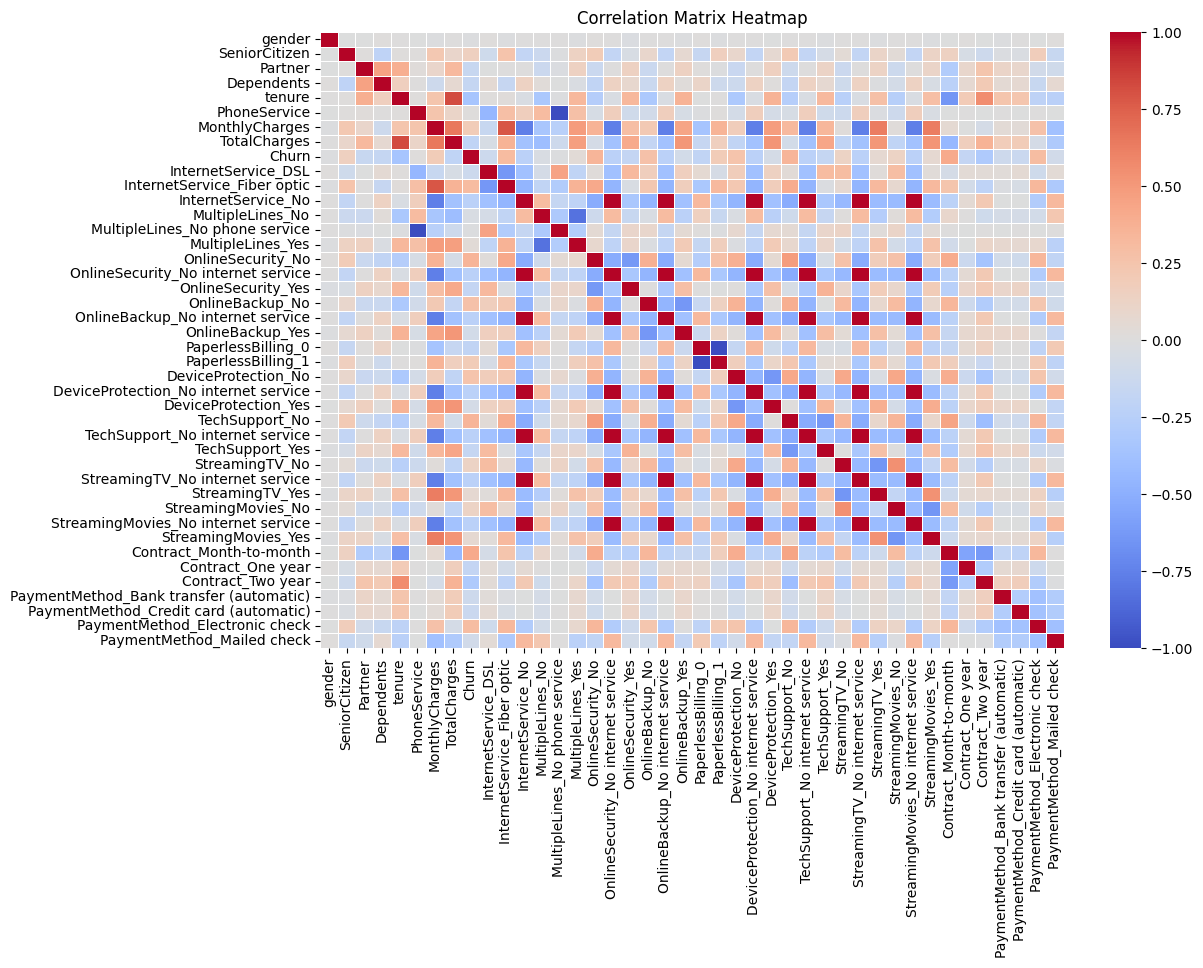

In [13]:
# Drop customerID as it is not useful
df = df.drop(columns=["customerID"])

# convert gender to 0's and 1's
df["gender"] = df["gender"].map({"Female": 0, "Male": 1})
df = df.infer_objects(copy=False) 

# Convert binary categorical variables to numeric (Yes=1, No=0)
binary_cols = ["Partner", "Dependents", "PhoneService", "Churn", "PaperlessBilling" ]
for col in binary_cols:
    df[col] = df[col].replace({"Yes": 1, "No": 0})
    df = df.infer_objects(copy=False) 

# One-hot encode multi-category variables
df = pd.get_dummies(df, columns=multiCategories, drop_first=False)

bool_cols = df.select_dtypes(include=bool).columns
df[bool_cols] = df[bool_cols].astype(int)

# Compute correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

logger.log('data transformation completed, data is ready to use for training')


In [16]:
# Get correlation values
correlation_with_churn = df.corr()["Churn"].sort_values(ascending=False)

# Print the correlation values
print(correlation_with_churn)

Churn                                      1.000000
Contract_Month-to-month                    0.406709
OnlineSecurity_No                          0.345919
TechSupport_No                             0.344261
InternetService_Fiber optic                0.310652
PaymentMethod_Electronic check             0.304117
OnlineBackup_No                            0.269801
DeviceProtection_No                        0.256601
MonthlyCharges                             0.194667
PaperlessBilling_1                         0.192209
SeniorCitizen                              0.150098
StreamingTV_No                             0.131713
StreamingMovies_No                         0.131073
StreamingMovies_Yes                        0.063771
StreamingTV_Yes                            0.062983
MultipleLines_Yes                          0.038856
PhoneService                               0.010328
gender                                    -0.008600
MultipleLines_No phone service            -0.010328
MultipleLine

In [17]:
df["customerID"] = master_df["customerID"]
df.to_csv(os.path.join('master csv', today, "prepared_data.csv"), index=False)